In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Activation,Dropout, LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from numpy import array

2021-09-24 12:27:29.491388: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-24 12:27:29.491417: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
df = pd.read_csv("/home/wojtek/Desktop/emotion_recognition/dataset/internet_dataset/final_dataset_v8_top_3000_spellchecked.csv", sep=',')

In [7]:
df.head()

,emotion,comment
0,happiness,period fall love time meet especially not meet...
1,fear,involve traffic accident
2,anger,drive home several day hard work motorist ahea...
3,sadness,lose person meant
4,disgust,time knock deer sight animal injury helplessne...


In [8]:
X = df['comment']
y = df['emotion']

In [9]:
y.value_counts()

happiness    3000
fear         3000
anger        3000
sadness      3000
disgust      3000
surprise     2999
Name: emotion, dtype: int64

In [10]:
text = df['comment'].tolist()

In [11]:
token = Tokenizer()
token.fit_on_texts(text)

In [12]:
vocab_size = len(token.word_index) + 1

In [13]:
vocab_size

19097

In [14]:
# token.index_word

In [15]:
encoded_text = token.texts_to_sequences(text)
encoded_text[:3]

[[814, 360, 30, 10, 122, 529, 1, 122, 82, 10],
 [678, 896, 320],
 [216,
  31,
  306,
  6,
  175,
  15,
  9237,
  963,
  216,
  269,
  126,
  399,
  633,
  447,
  1442,
  93,
  2760]]

In [16]:
max_length = 120 # machine learning potrzebuje żeby zdania były max sized (pewnie pozostałe to 0)
X = pad_sequences(encoded_text, maxlen=max_length, padding='post') # padding post po to, by 0 byly dodane na koncu listy
X

array([[  814,   360,    30, ...,     0,     0,     0],
       [  678,   896,   320, ...,     0,     0,     0],
       [  216,    31,   306, ...,     0,     0,     0],
       ...,
       [19096,    20,   395, ...,     0,     0,     0],
       [  192,  1144,    73, ...,     0,     0,     0],
       [  100,   509,  3340, ...,     0,     0,     0]], dtype=int32)

In [17]:
X.shape

(17999, 120)

In [18]:
###`GloVe` Vectors

In [26]:
path_to_glove_file = "/home/wojtek/Desktop/emotion_recognition/pretrained_vectors/glove.6B.100d.txt"

In [27]:
glove_vectors = dict()

In [28]:
%%time
with open(path_to_glove_file) as file:
    for line in file:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:])  # list will be converted as array
        glove_vectors[word] = vectors

CPU times: user 6.15 s, sys: 2.11 s, total: 8.26 s
Wall time: 10.3 s


In [29]:
len(glove_vectors.keys())

400000

In [30]:
glove_vectors.get('you').shape

(100,)

In [31]:
word_vector_matrix = np.zeros((vocab_size, 100))

In [32]:
for word, index in token.word_index.items():
    vector = glove_vectors.get(word)
    if vector is not None:
        word_vector_matrix[index] = vector
    # else:
        # print(word)

In [33]:
### TF2.0 and Keras Model Building

In [34]:
X

array([[  814,   360,    30, ...,     0,     0,     0],
       [  678,   896,   320, ...,     0,     0,     0],
       [  216,    31,   306, ...,     0,     0,     0],
       ...,
       [19096,    20,   395, ...,     0,     0,     0],
       [  192,  1144,    73, ...,     0,     0,     0],
       [  100,   509,  3340, ...,     0,     0,     0]], dtype=int32)

In [35]:
y

0        happiness
1             fear
2            anger
3          sadness
4          disgust
           ...    
17994     surprise
17995     surprise
17996     surprise
17997     surprise
17998     surprise
Name: emotion, Length: 17999, dtype: object

In [36]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [37]:
le = LabelEncoder()
y_label = le.fit_transform(y)
y_label = to_categorical(y_label, num_classes=6)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y_label, random_state=42, test_size=0.2)

In [39]:
y_train.shape

(14399, 6)

In [40]:
X_train.shape

(14399, 120)

In [41]:
vec_size = 100

In [42]:
model = Sequential()
model.add(Embedding(vocab_size, 
                    vec_size, 
                    input_length=max_length, 
                    weights=[word_vector_matrix], 
                    trainable=False)) # wagi to sa wektory

model.add(Conv1D(64, 8, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
    
model.add(Dense(16, activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(6, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test))

2021-09-24 12:28:37.729811: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-24 12:28:37.729840: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-24 12:28:37.729858: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (wojtek-VirtualBox): /proc/driver/nvidia/version does not exist
2021-09-24 12:28:37.730155: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-24 12:28:38.149669: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR 

Epoch 1/60
  3/450 [..............................] - ETA: 26s - loss: 2.2385 - accuracy: 0.1458

2021-09-24 12:28:38.879380: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19164800 exceeds 10% of free system memory.
2021-09-24 12:28:38.930356: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19164800 exceeds 10% of free system memory.
2021-09-24 12:28:38.995489: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19164800 exceeds 10% of free system memory.
2021-09-24 12:28:39.055187: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19164800 exceeds 10% of free system memory.


  8/450 [..............................] - ETA: 26s - loss: 2.2674 - accuracy: 0.1250

2021-09-24 12:28:39.120333: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19164800 exceeds 10% of free system memory.


450/450 [==============================] - 15s 32ms/step - loss: 1.8761 - accuracy: 0.1706 - val_loss: 1.7855 - val_accuracy: 0.1750
Epoch 2/60
450/450 [==============================] - 14s 31ms/step - loss: 1.7932 - accuracy: 0.1927 - val_loss: 1.7759 - val_accuracy: 0.2269
Epoch 3/60
450/450 [==============================] - 20s 45ms/step - loss: 1.7674 - accuracy: 0.2201 - val_loss: 1.7571 - val_accuracy: 0.2711
Epoch 4/60
450/450 [==============================] - 20s 45ms/step - loss: 1.7346 - accuracy: 0.2525 - val_loss: 1.7208 - val_accuracy: 0.3069
Epoch 5/60
450/450 [==============================] - 20s 45ms/step - loss: 1.6872 - accuracy: 0.2766 - val_loss: 1.6617 - val_accuracy: 0.3178
Epoch 6/60
450/450 [==============================] - 20s 45ms/step - loss: 1.6347 - accuracy: 0.3020 - val_loss: 1.5980 - val_accuracy: 0.3536
Epoch 7/60
450/450 [==============================] - 18s 40ms/step - loss: 1.5860 - accuracy: 0.3290 - val_loss: 1.5453 - val_accuracy: 0.3878
Epo

In [88]:
model3 = Sequential()
model3.add(Embedding(vocab_size,
                     vec_size,
                     input_length=max_length,
                     weights=[word_vector_matrix],
                     trainable=False)) # wagi to sa wektory

model3.add(Conv1D(128, 3, activation='relu'))
model3.add(MaxPooling1D(5))
model3.add(Dropout(0.3))

model3.add(Conv1D(128, 3, activation='relu'))
model3.add(MaxPooling1D(5))
model3.add(Dropout(0.3))

model3.add(Conv1D(128, 3, activation='relu'))
model3.add(GlobalMaxPooling1D())
model3.add(Dropout(0.3))

model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.3))
    
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.3))
# model.add(GlobalMaxPooling1D())

model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.5))

model3.add(Dense(6, activation='softmax'))

model3.compile(optimizer='adam', 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])
history3 = model3.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/40
450/450 [==============================] - 15s 33ms/step - loss: 1.6849 - accuracy: 0.2312 - val_loss: 1.5063 - val_accuracy: 0.3081
Epoch 2/40
450/450 [==============================] - 16s 35ms/step - loss: 1.5161 - accuracy: 0.3066 - val_loss: 1.4322 - val_accuracy: 0.3789
Epoch 3/40
450/450 [==============================] - 14s 31ms/step - loss: 1.4237 - accuracy: 0.3801 - val_loss: 1.3311 - val_accuracy: 0.4247
Epoch 4/40
450/450 [==============================] - 24s 53ms/step - loss: 1.3021 - accuracy: 0.4427 - val_loss: 1.2238 - val_accuracy: 0.4872
Epoch 5/40
450/450 [==============================] - 20s 45ms/step - loss: 1.2435 - accuracy: 0.4736 - val_loss: 1.2181 - val_accuracy: 0.5069
Epoch 6/40
450/450 [==============================] - 22s 50ms/step - loss: 1.1883 - accuracy: 0.4875 - val_loss: 1.1746 - val_accuracy: 0.5122
Epoch 7/40
450/450 [==============================] - 17s 38ms/step - loss: 1.1484 - accuracy: 0.5199 - val_loss: 1.1713 - val_accuracy:

In [156]:
pred = model.predict(X_test[1:2])

In [157]:
pred

array([[0.03753073, 0.01475197, 0.20454566, 0.30121052, 0.23221147,
        0.20974961]], dtype=float32)

In [158]:
pred[0:1]

array([[0.03753073, 0.01475197, 0.20454566, 0.30121052, 0.23221147,
        0.20974961]], dtype=float32)

In [159]:
np.argmax(pred[0:1], axis=None, out=None)

3

In [160]:
result = (-pred).argsort()[:2]

In [161]:
top_prediction, secondary_prediction = result[0][0], result[0][1]

In [162]:
top_prediction

3

In [134]:
y_test[1:2]

array([[0., 0., 0., 0., 0., 1.]], dtype=float32)

In [135]:
np.argmax(y_test[0:1], axis=None, out=None)

0

In [136]:
le.inverse_transform((np.argmax(y_test[0:1], axis=None, out=None),))[0]

'anger'

In [137]:
le.inverse_transform((np.argmax(pred[0:1], axis=None, out=None),))[0]

'anger'

array([], shape=(0, 6), dtype=float32)

In [100]:
pred[0][np.argmax(pred[0:1], axis=None, out=None)]

0.9998349

In [101]:
len(y_test)

3600

In [106]:
X_test[0:1][0]

array([ 105,   17,    1,  110,  998,  473,  283,  710,   44, 1291,   18,
        555,   24,  177,   47,  555,   21,  163,    4,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [109]:
tokenizer.sequences_to_texts(X_test[0:1][0])

NameError: name 'tokenizer' is not defined

In [110]:
reverse_word_map = dict(map(reversed, token.word_index.items()))

In [115]:
reverse_word_map = dict(map(reversed, token.word_index.items()))
sentence = []
for i in X_test[0:1][0]:
    if i == 0:
        break
    sentence.append(reverse_word_map[i])
' '.join(sentence)

'parent think not best pas final examination secondary school achieve good grade say nothing bad grade would become angry'

In [170]:
# for i in range(len(y_test)+1):
for i in range(200):
    pred = model.predict(X_test[i:i+1])
    another_pred = (-pred).argsort()[:2]
    pred = le.inverse_transform((np.argmax(pred, axis=None, out=None),))[0]
    result = le.inverse_transform((np.argmax(y_test[i:i+1], axis=None, out=None),))[0]
    prim_pred = le.inverse_transform((another_pred[0][0],))[0]
    sec_pred = le.inverse_transform((another_pred[0][1],))[0]
    if pred != result:
        sentence = []
        for a in X_test[i:i+1][0]:
            if a == 0:
                break
            sentence.append(reverse_word_map[a])
        classified_sentence = ' '.join(sentence)
        print("sentence")
        print(classified_sentence)
        print("result")
        print(result)
        print("prediction")
        print(pred)
        print("primary prediction")
        print(prim_pred)
        print("secondary prediction")
        print(sec_pred)
        print("----")

sentence
trivia work no computer
result
surprise
primary prediction
happiness
secondary prediction
sadness
----
sentence
yeah well sorry not believe kiss sa
result
surprise
primary prediction
sadness
secondary prediction
fear
----
sentence
friend promise would definitely call tell visit not
result
anger
primary prediction
happiness
secondary prediction
sadness
----
sentence
watch series call dynasty detest
result
disgust
primary prediction
fear
secondary prediction
sadness
----
sentence
sorry suck know ve yay half day though
result
fear
primary prediction
happiness
secondary prediction
surprise
----
sentence
new project go incredibly well not tire today think get monday permanently
result
happiness
primary prediction
sadness
secondary prediction
fear
----
sentence
think haircut isnt bad look yesterday still bad tho
result
surprise
primary prediction
sadness
secondary prediction
fear
----
sentence
alive go notebook all make cry stuff
result
surprise
primary prediction
sadness
secondary 

In [128]:
le.inverse_transform((np.argmax(pred[0:1], axis=None, out=None),))[0]

'anger'

In [130]:
pred

'surprise'

In [46]:
model5 = Sequential()
model5.add(Embedding(vocab_size, 
                     vec_size, 
                     input_length=max_length, 
                     weights=[word_vector_matrix], 
                     trainable=False)) # wagi to sa wektory

model5.add(Conv1D(128, 3, activation='relu'))
model5.add(MaxPooling1D(5))

model5.add(Conv1D(64, 3, activation='relu'))
model5.add(MaxPooling1D(2))
model5.add(Dropout(0.3))

model5.add(Dense(32, activation='relu'))
model5.add(Dropout(0.3))
    
model5.add(Dense(16, activation='relu'))
model5.add(GlobalMaxPooling1D())

model5.add(Dense(6, activation='softmax'))

model5.compile(optimizer=Adam(learning_rate=0.0001), 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])
history5 = model5.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/60
450/450 [==============================] - 11s 23ms/step - loss: 1.7774 - accuracy: 0.2079 - val_loss: 1.7297 - val_accuracy: 0.2506
Epoch 2/60
450/450 [==============================] - 10s 22ms/step - loss: 1.7234 - accuracy: 0.2454 - val_loss: 1.6692 - val_accuracy: 0.2917
Epoch 3/60
450/450 [==============================] - 10s 23ms/step - loss: 1.6415 - accuracy: 0.2970 - val_loss: 1.5612 - val_accuracy: 0.3500
Epoch 4/60
450/450 [==============================] - 10s 21ms/step - loss: 1.5388 - accuracy: 0.3420 - val_loss: 1.4517 - val_accuracy: 0.3936
Epoch 5/60
450/450 [==============================] - 10s 23ms/step - loss: 1.4453 - accuracy: 0.3881 - val_loss: 1.3817 - val_accuracy: 0.4250
Epoch 6/60
450/450 [==============================] - 10s 23ms/step - loss: 1.3846 - accuracy: 0.4233 - val_loss: 1.3316 - val_accuracy: 0.4481
Epoch 7/60
450/450 [==============================] - 10s 22ms/step - loss: 1.3380 - accuracy: 0.4414 - val_loss: 1.2928 - val_accuracy:

In [4]:
history3

NameError: name 'history3' is not defined

In [120]:
model4 = Sequential()
model4.add(Embedding(vocab_size, 
                     vec_size, 
                     input_length=max_length, 
                     weights=[word_vector_matrix], 
                     trainable=False)) # wagi to sa wektory

# model4.add(LSTM(128, return_sequences=True))

model4.add(Conv1D(128, 3, activation='relu'))
model4.add(MaxPooling1D(5))

model4.add(Conv1D(64, 3, activation='relu'))
model4.add(MaxPooling1D(2))
model4.add(Dropout(0.3))

model4.add(Dense(32, activation='relu'))
model4.add(Dropout(0.3))

model4.add(Dense(16, activation='relu'))
model4.add(GlobalMaxPooling1D())

model4.add(Dense(6, activation='softmax'))

model4.compile(optimizer=Adam(learning_rate=0.0001), 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])
history4 = model4.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/30
450/450 [==============================] - 26s 56ms/step - loss: 1.7696 - accuracy: 0.2123 - val_loss: 1.7220 - val_accuracy: 0.2483
Epoch 2/30
450/450 [==============================] - 25s 55ms/step - loss: 1.7054 - accuracy: 0.2525 - val_loss: 1.6477 - val_accuracy: 0.3008
Epoch 3/30
450/450 [==============================] - 24s 53ms/step - loss: 1.6304 - accuracy: 0.2913 - val_loss: 1.5628 - val_accuracy: 0.3394
Epoch 4/30
450/450 [==============================] - 25s 57ms/step - loss: 1.5534 - accuracy: 0.3359 - val_loss: 1.4680 - val_accuracy: 0.4028
Epoch 5/30
450/450 [==============================] - 20s 44ms/step - loss: 1.4701 - accuracy: 0.3839 - val_loss: 1.3941 - val_accuracy: 0.4331
Epoch 6/30
450/450 [==============================] - 19s 43ms/step - loss: 1.3970 - accuracy: 0.4196 - val_loss: 1.3232 - val_accuracy: 0.4750
Epoch 7/30
450/450 [==============================] - 17s 39ms/step - loss: 1.3348 - accuracy: 0.4519 - val_loss: 1.2773 - val_accuracy:

In [49]:
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


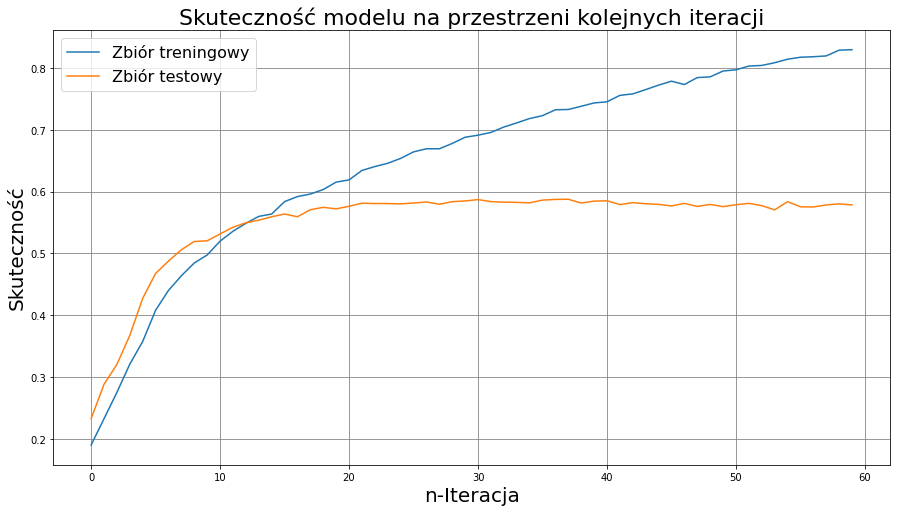

In [90]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Skuteczność modelu na przestrzeni kolejnych iteracji', size=22)
plt.ylabel('Skuteczność', size=20)
plt.xlabel('n-Iteracja', size=20)
plt.legend(['Zbiór treningowy', 'Zbiór testowy'], loc='upper left', prop={'size': 16})
plt.rcParams["figure.figsize"] = (15,8)
plt.grid(color='gray', linestyle='-')
# plt.show()
plt.savefig('plt1.png')



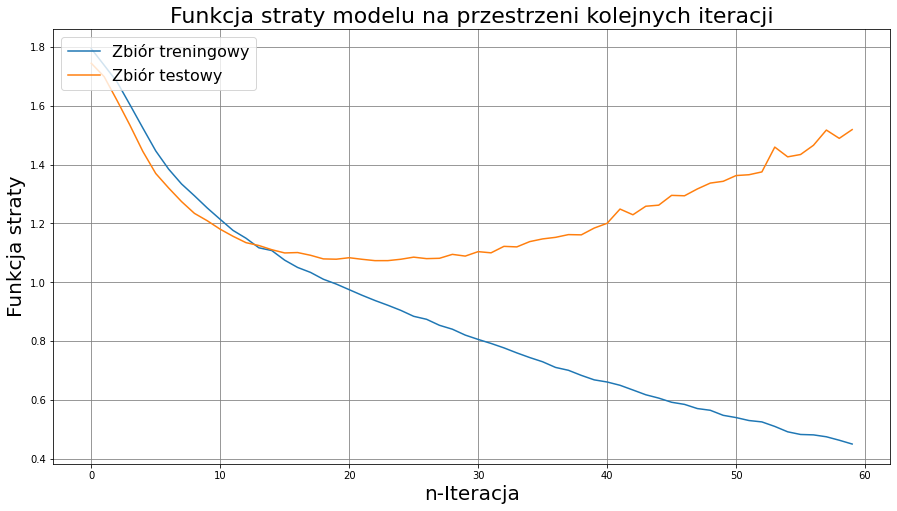

In [91]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Funkcja straty modelu na przestrzeni kolejnych iteracji', size=22)
plt.ylabel('Funkcja straty', size=20)
plt.xlabel('n-Iteracja', size=20)
plt.legend(['Zbiór treningowy', 'Zbiór testowy'], loc='upper left', prop={'size': 16})
plt.rcParams["figure.figsize"] = (15,8)
plt.grid(color='gray', linestyle='-')
# plt2.show()
plt.savefig('plt2.png')

In [121]:
reverse_word_map = dict(map(reversed, token.word_index.items()))
sentence = []
for i in X_test[0:1][0]:
    if i == 0:
        break
    sentence.append(reverse_word_map[i])
' '.join(sentence)

results = []

for i in range(len(y_test)+1):
# for i in range(200):
#     print(X_test[i:i+1])
    try:
        pred = model4.predict(X_test[i:i+1])
    except ValueError:
        continue
    another_pred = (-pred).argsort()[:2]
    pred = le.inverse_transform((np.argmax(pred, axis=None, out=None),))[0]
    result = le.inverse_transform((np.argmax(y_test[i:i+1], axis=None, out=None),))[0]
    prim_pred = le.inverse_transform((another_pred[0][0],))[0]
    sec_pred = le.inverse_transform((another_pred[0][1],))[0]
    if pred != result:
        sentence = []
        for a in X_test[i:i+1][0]:
            if a == 0:
                break
            sentence.append(reverse_word_map[a])
        classified_sentence = ' '.join(sentence)
#         print("sentence")
#         print(classified_sentence)
#         print("result")
#         print(result)
#         print("primary prediction")
#         print(prim_pred)
#         print("secondary prediction")
#         print(sec_pred)
#         print("----")
        results.append([classified_sentence, result, prim_pred, sec_pred])
    
df_misclassified = pd.DataFrame(results, columns=['Sentence', 'Result', 'Primary Prediction', 'Secondary Prediction'])

In [122]:
df_misclassified

,Sentence,Result,Primary Prediction,Secondary Prediction
0,trivia work no computer,surprise,fear,sadness
1,yeah well sorry not believe kiss sa,surprise,sadness,fear
2,friend promise would definitely call tell visi...,anger,sadness,fear
3,watch series call dynasty detest,disgust,surprise,happiness
4,sorry suck know ve yay half day though,fear,sadness,surprise
...,...,...,...,...
1522,friend wake middle blissful sleep knock door s...,disgust,fear,sadness
1523,art streetcar,anger,fear,happiness
1524,hollyhocks curse justin strike date burton end...,sadness,fear,anger
1525,fell think knee broken look fabulous,sadness,happiness,surprise


In [123]:
len(y_test)

3600

In [124]:
df_misclassified[df_misclassified['Result'] == df_misclassified['Secondary Prediction']]

,Sentence,Result,Primary Prediction,Secondary Prediction
9,massive headache,sadness,fear,sadness
10,make boyfriend look different cute no matter,surprise,happiness,surprise
13,faux goth chick look sorry not go camden like ...,surprise,sadness,surprise
14,foot kill ve walk mile search art shop not see...,sadness,fear,sadness
15,ooooooooh get pyjama,surprise,happiness,surprise
...,...,...,...,...
1517,apparently misplace ipod go,sadness,surprise,sadness
1518,red blue,surprise,happiness,surprise
1520,humpalow um ya think cell die,fear,sadness,fear
1521,work still sick,sadness,fear,sadness


In [125]:
df_misclassified.pivot_table(index="Result", columns="Secondary Prediction", values="Secondary Prediction", aggfunc='count')

ValueError: Grouper for 'Secondary Prediction' not 1-dimensional

In [139]:
df_misclassified["Result"].groupby([df_misclassified["Result"], df_misclassified["Secondary Prediction"]]).size().unstack().fillna(0).astype(int)

Secondary Prediction,anger,disgust,fear,happiness,sadness,surprise
Result,,,,,,
anger,41,3,27,23,52,18
disgust,10,25,34,7,30,21
fear,11,12,162,40,38,58
happiness,14,5,53,100,59,7
sadness,22,13,27,34,196,41
surprise,20,4,86,25,78,131


In [138]:
df_misclassified["Result"].groupby([df_misclassified["Result"], df_misclassified["Primary Prediction"]]).size().unstack().fillna(0).astype(int)

Primary Prediction,anger,disgust,fear,happiness,sadness,surprise
Result,,,,,,
anger,0,26,72,30,19,17
disgust,40,0,40,25,15,7
fear,33,25,0,84,150,29
happiness,16,11,61,0,68,82
sadness,27,13,161,87,0,45
surprise,16,16,71,141,100,0


In [140]:
df_completely_misclassified = df_misclassified[df_misclassified['Result'] != df_misclassified['Secondary Prediction']]

In [141]:
df_completely_misclassified

,Sentence,Result,Primary Prediction,Secondary Prediction
0,trivia work no computer,surprise,fear,sadness
1,yeah well sorry not believe kiss sa,surprise,sadness,fear
2,friend promise would definitely call tell visi...,anger,sadness,fear
3,watch series call dynasty detest,disgust,surprise,happiness
4,sorry suck know ve yay half day though,fear,sadness,surprise
...,...,...,...,...
1519,roommate talk shake bed night,disgust,anger,fear
1522,friend wake middle blissful sleep knock door s...,disgust,fear,sadness
1523,art streetcar,anger,fear,happiness
1524,hollyhocks curse justin strike date burton end...,sadness,fear,anger


In [142]:
df_completely_misclassified["Result"].groupby([df_completely_misclassified["Result"], df_completely_misclassified["Primary Prediction"]]).size().unstack().fillna(0).astype(int)

Primary Prediction,anger,disgust,fear,happiness,sadness,surprise
Result,,,,,,
anger,0,8,53,30,19,13
disgust,21,0,36,24,15,6
fear,14,10,0,76,31,28
happiness,15,9,57,0,46,11
sadness,27,13,19,47,0,31
surprise,9,16,71,30,87,0


In [143]:
df_completely_misclassified.head(100)

,Sentence,Result,Primary Prediction,Secondary Prediction
0,trivia work no computer,surprise,fear,sadness
1,yeah well sorry not believe kiss sa,surprise,sadness,fear
2,friend promise would definitely call tell visi...,anger,sadness,fear
3,watch series call dynasty detest,disgust,surprise,happiness
4,sorry suck know ve yay half day though,fear,sadness,surprise
...,...,...,...,...
153,man cant go sunday cause im help day piano rec...,surprise,sadness,fear
154,wish could buy mental peace,anger,fear,sadness
156,bee stung eye im sorry,surprise,fear,sadness
157,halloo barn halloo stay,happiness,fear,sadness


In [153]:
df_completely_misclassified.head(100).tail(95).head(10)

,Sentence,Result,Primary Prediction,Secondary Prediction
5,think haircut isnt bad look yesterday still ba...,surprise,sadness,fear
6,alive go notebook all make cry stuff,surprise,fear,sadness
7,see maltreat dead animal,disgust,fear,sadness
8,think might break purchase u donot know call,fear,surprise,happiness
11,hear people talk back,disgust,happiness,surprise
12,landlord put rent sneaky simply,anger,fear,sadness
16,tom tour philippine please would awesome,fear,surprise,happiness
18,one friend ask go shop another friend also com...,anger,fear,sadness
19,happy pass go form great relief worry consider...,happiness,fear,sadness
20,aww poor know u bless,happiness,sadness,fear
